# Deskripsi
Deskripsi mengenai variable-variabel yang ada dalam penelitian ini akan dijelaskan dalam beberapa bagian:

1. Loading and General Description
2. Crawling indicator Description
3. 'News' Variables Description

## 0. Load Library

In [2]:
import matplotlib.pyplot as plt
import os, re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from datetime import datetime as dt
import cPickle as pickle
import re #Regex
import seaborn as sns
sns.set()
%matplotlib inline

## 1. Load and General Description

In [4]:
import MySQLdb
import pandas as pd

mysql_cn = MySQLdb.connect(host = "localhost",
                     user = "root",
                     passwd = "",
                     db = "news_yii2-07092016")
#                      db = "news_yii2-backup")
df_mysql = pd.read_sql('select * from news;', con=mysql_cn,index_col='id')
dfNewsLink_mysql = pd.read_sql('select * from newslink;', con=mysql_cn, index_col='id')
mysql_cn.close()

print df_mysql.shape

(58446, 11)


In [6]:
df_mysql[df_mysql.index == 12000].values

array([[Timestamp('2016-04-28 15:06:03'), NaT, 5L,
        'http://economy.okezone.com/read/2016/04/28/20/1375054/dana-repatriasi-tax-amnesty-tak-harus-ditempatkan-di-bank-besar',
        'Dana Repatriasi Tax Amnesty Tak Harus Ditempatkan di Bank Besar',
        'OJK menilai pemulangan dana warga negara RI  yang diparkir di luar negeri (dana repatriasi) tidak harus ditempatkan  di bank besar.',
        '\t\t\t\t\t\t\tJAKARTA - Otoritas Jasa Keuangan (OJK) menilai pemulangan dana warga negara RI yang diparkir di luar negeri (dana repatriasi) tidak harus ditempatkan di bank besar. Bank-bank kelas BUKU I dan II juga bisa dijadikan tempat menaruh dana repatriasi.Ketua Dewan Komisioner OJK Muliaman D Hadad berpendapat, terpenting adalah perbankan Indonesia menyiapkan instrumen produk keuangan. Dia bilang, dana repatriasi bisa dimasukkan ke dalam instrumen keuangan seperti investasi di pasar modal hingga produk keuangan di perbankan.&nbsp;[Baca juga: Jokowi Diminta Bujuk Pengusaha Kembalikan

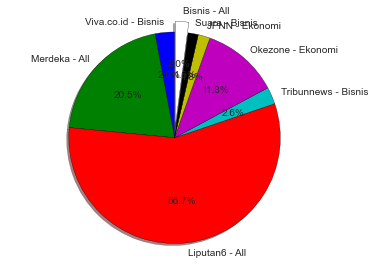

In [55]:
dataPie = df_mysql.groupby(['sumber'])['url'].count()
describ = dfNewsLink_mysql['descr'].tolist()

labels = describ
sizes = dataPie
explode = [0]*len(labels)  # only "explode" the 2nd slice (i.e. 'Hogs')

#Sorot Liputan6 yang id=3, tapi karena dari 0, jadi 2
explode[7]=.1

plt.pie(sizes, explode=explode, labels=labels,
         autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

fig = plt.figure()

In [56]:
print dfNewsLink_mysql.shape
dfNewsLink_mysql[dfNewsLink_mysql.index == 3]

(8, 3)


,descr,url,crawlClass
id,,,
3,Liputan6 - All,http://www.liputan6.com/feed/rss2,div=itemprop=description


In [57]:
from collections import Counter
newsByDate = df_mysql[~df_mysql.published.isnull()]
counted_dates = Counter(newsByDate.published.apply(lambda x: x.strftime("%Y-%m-%d")))
counted_series = pd.Series(counted_dates)
print 'Awal Crawl  : ',counted_series.head(1).index.values
print 'Akhir Crawl : ',counted_series.tail(1).index.values

Awal Crawl  :  ['2016-04-18']
Akhir Crawl :  ['2016-06-10']


In [58]:
import datetime as dt

def countByHour(x):
    newsByDate = x[~x.published.isnull()]
    counted_dates = Counter(newsByDate.created_at.apply(lambda x: x.strftime("%H")))
    counted_series = pd.Series(counted_dates)
    return counted_series

def countByDay(x):
    newsByDate = x[~x.published.isnull()]
    counted_dates = Counter(newsByDate.created_at.apply(lambda x: x.strftime("%Y-%m-%d")))
    counted_series = pd.Series(counted_dates)
    counted_series.index = pd.to_datetime(counted_series.index)
    return counted_series

def countByWeek(x):
    newsByDate = x[~x.published.isnull()]
    counted_dates = Counter(newsByDate.created_at.apply(lambda x: x.weekday()))
    counted_series = pd.Series(counted_dates)
    return counted_series

byHour = countByHour(df_mysql)
byDate = countByDay(df_mysql)
byWeek = countByWeek(df_mysql)

In [59]:
top3hour = byHour.sort_values(ascending=False).head(3)
top3day  = byWeek.sort_values(ascending=False).head(3)
print 'Jam paling produktif  : \n',top3hour.index.values,'\n',top3hour.values
print 'Hari paling produktif : \n',top3day.index.values,'\n',top3day.values

Jam paling produktif  : 
['15' '12' '19'] 
[4051 4009 3809]
Hari paling produktif : 
[2 1 0] 
[10903 10599  9038]


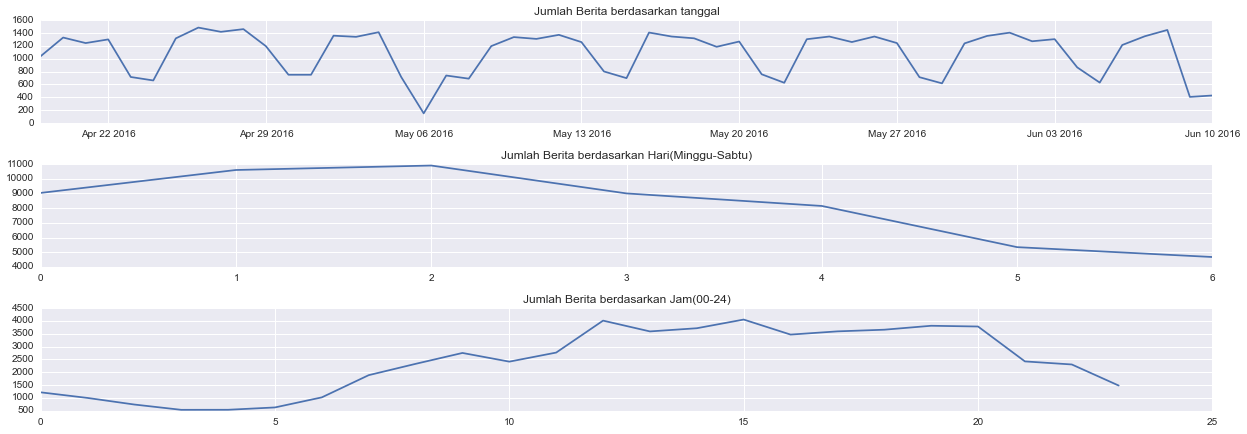

In [60]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime

fig, axes = plt.subplots(nrows=3,figsize=(21,7))
axes[0].plot_date(date2num(byDate.index.to_pydatetime()),byDate.values,'-')
axes[0].set_title('Jumlah Berita berdasarkan tanggal')
axes[1].plot(byWeek.index,byWeek.values)
axes[1].set_title('Jumlah Berita berdasarkan Hari(Minggu-Sabtu)')
axes[2].plot(byHour.index,byHour.values)
axes[2].set_title('Jumlah Berita berdasarkan Jam(00-24)')

fig.subplots_adjust(hspace = 0.4)
fig.show()

### Insight

1. Total Daily
       Dari plot pertama, bisa dilihat bahwa jumlah berita yang muncul per harinya cenderung berpola naik dan turun secara teratur. Pola tersebut ada berdasarkan perbedaan hari.
   
2. Total Weekly
       Unik karena ternyata jumlah berita yang muncul menurun pada hari kerja, dan mulai naik lagi dari hari minggu, mungkin karena hari jumat dan sabtu banyak kantor-kantor yang sudah tidak aktif secara penuh lagi, sehingga sumber-sumber berita berkurang
   
3. Total Hourly
       jumlah berita mencapai puncaknya jam 12 siang, namun sudah tinggi sejak pagi. Mungkin terkait jam kerja reporter, jumlah berita langsung menurun sedari jam 12 dan jumlah berita yang paling sedikit ada di jam 19-21. Mungkin karena reporter yang mendapatkan berita pada malam hari dipublikasinya pagi esoknya, jumlah berita mulai naik pukul 22 hingga esok paginya. 

## 1. Crawling Indicator

In [61]:
DATA_ANALSISIS_crawl = df_mysql[df_mysql.crawlMem.notnull()] #Yang sudah di crawl
crawlIndicator = pd.DataFrame([DATA_ANALSISIS_crawl.crawlMem,DATA_ANALSISIS_crawl.crawlTime]).transpose()
pickle.dump(DATA_ANALSISIS_crawl, open( "v1.4\DATA_ANALSISIS_crawl-v2.p", "wb" ) )
crawlIndicator.describe()

,crawlMem,crawlTime
count,42746.000000,42746.000000
mean,3362.689187,0.992690
std,587.077727,59.015039
min,2080.000000,0.000000
25%,2808.000000,0.210900
50%,3408.000000,0.467200
75%,3520.000000,0.625200
max,7000.000000,12196.766600


### Clear unrelated link

In [62]:
mysql_cn = MySQLdb.connect(host = "localhost",
                     user = "root",
                     passwd = "",
                     db = "news_yii2-19082016")
df_mysqlFilter = pd.read_sql('select * from news_filter;', con=mysql_cn)
mysql_cn.close()

print df_mysqlFilter.shape

(24, 4)


In [63]:
df_mysqlFilter.head()

,id,newslink_id,filter,klasifikasi
0,44,3,http://showbiz.liputan6,1
1,45,3,http://regional.liputan6.com,1
2,46,3,http://bola.liputan6.com,1
3,47,3,http://video.liputan6.com,1
4,48,3,http://photo.liputan6.com,1


In [66]:
#Exclude newses that are not economy/finance topic
df_mysqlClear = pd.DataFrame(DATA_ANALSISIS_crawl)
for fltr in df_mysqlFilter['filter'] :
    df_mysqlClear = df_mysqlClear.drop(df_mysqlClear[df_mysqlClear.url.str.startswith(fltr)].index)

DATA_ANALSISIS_crawl = df_mysqlClear
#pickle.dump(DATA_ANALSISIS_crawl, open( "v1.4\DATA_ANALSISIS_crawl-v3.p", "wb" ) )
DATA_ANALSISIS_crawl.describe()

,sumber,crawlTime,crawlMem,flag
count,23227.000000,23227.000000,23227.000000,23219.000000
mean,3.637964,0.665803,3477.895553,-0.039537
std,1.496352,2.002989,639.275300,0.302152
min,1.000000,0.000000,2080.000000,-2.000000
25%,3.000000,0.143000,2936.000000,0.000000
50%,3.000000,0.358600,3408.000000,0.000000
75%,5.000000,0.586900,3960.000000,0.000000
max,8.000000,120.553800,7000.000000,1.000000


In [67]:
DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag.isin([-1,1])].count()

created_at     941
updated_at     780
sumber        1252
url           1252
judul         1252
shortDesc     1252
longDesc      1252
published      930
crawlTime     1252
crawlMem      1252
flag          1252
dtype: int64

In [57]:
# DA4 = DATA_ANALSISIS_crawl
# mysql_cn = MySQLdb.connect(host = "localhost",
#                      user = "root",
#                      passwd = "",
#                      db = "news_yii2-19082016")
# cursor = mysql_cn.cursor()
# for i in DA4.index.values:
#     if (DA4[DA4.index==i].flag.values[0] == 1):
#         query = str.format("UPDATE `news_yii2-19082016`.`news` SET `flag` = '1' WHERE `news`.`id` = %d"%(i))
#         cursor.execute(query)
#     elif (DA4[DA4.index==i].flag.values[0] == -1):
#         query = str.format("UPDATE `news_yii2-19082016`.`news` SET `flag` = '-3' WHERE `news`.`id` = %d"%(i))
#         cursor.execute(query)
        
# # for i in op.index.values:
# #     query = str.format("UPDATE `news_yii2-19082016`.`news` SET `flag` = '2' WHERE `news`.`id` = %d"%(i))
# #     cursor.execute(query)

# # cursor.execute("UPDATE `news_yii2-19082016`.`news` SET `flag` = '0' WHERE `news`.`flag` = 1;")
# cursor.execute("UPDATE `news_yii2-19082016`.`news` SET `flag` = '-2' WHERE `news`.`flag` = -1;")
# # cursor.execute("UPDATE `news_yii2-19082016`.`news` SET `flag` = '1' WHERE `news`.`flag` = 3;")
# cursor.execute("UPDATE `news_yii2-19082016`.`news` SET `flag` = '-1' WHERE `news`.`flag` = -3;")

# mysql_cn.commit()
# mysql_cn.close()

In [19]:
#Take only labeled data, labeled means value of 'flag' attribute that either -1 or 1
# DATA_ANALISIS3 = df_mysqlClear[df_mysqlClear.crawlMem.notnull()][df_mysqlClear.flag.isin([-1,1])]
DATA_ANALISIS3= df_mysql[df_mysql.crawlMem.notnull()][df_mysql.flag.isin([-1,1])]

DATA_JUDUL = DATA_ANALISIS3.judul
DATA_SHORT = DATA_ANALISIS3.shortDesc
DATA_LONG  = DATA_ANALISIS3.longDesc
DATA_TARGET = DATA_ANALISIS3.flag

# print 'Number of Data that is related to business:',len(DATA_ANALISIS3)
print 'Number of Data that is related to business:',len(DATA_ANALISIS3)

Number of Data that is related to business: 1344


In [5]:
#Removing the HTML tags, similar with php's strip_tag + Removing punctuation
from HTMLParser import HTMLParser
import string

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    striped  = s.get_data()                         #get HTML-Tags free text
    lowers   = striped.lower()                      #Lowercase all words
    nospace  = lowers.strip()                      #Remove leading and trailing white space
    alphanum = re.sub(r'[^a-zA-Z]', ' ', nospace)
    return str(alphanum)

#alphanum = re.sub(r'[^a-zA-Z]', ' ', lowers) #Delete all but alphanumerical
#alphanum = re.sub(r'[^a-zA-Z0-9]', ' ', lowers) #Delete all but alphanumerical and number

In [6]:
DATA_JUDUL = df_mysql[~df_mysql.crawlMem.isnull()].judul
DATA_SHORT = df_mysql[~df_mysql.crawlMem.isnull()].shortDesc
DATA_LONG  = df_mysql[~df_mysql.crawlMem.isnull()].longDesc
DATA_JUDULStriped = DATA_JUDUL.map(lambda x: strip_tags(x))
DATA_SHORTStriped = DATA_SHORT.map(lambda x: strip_tags(x))
DATA_LONGStriped = DATA_LONG.map(lambda x: strip_tags(x))

In [27]:
strip_tags('2016 adalah tahun yang AmARR!!')

'     adalah tahun yang amarr  '

## Keyword Filtering

In [10]:
mysql_cn = MySQLdb.connect(host = "localhost",
                     user = "root",
                     passwd = "",
                     db = "news_yii2-19082016")
df_mysqlFilter = pd.read_sql('select * from klasifikasi_keyword;', con=mysql_cn)
mysql_cn.close()

print df_mysqlFilter.shape

(118, 3)


In [62]:
# keyword_dua = ['pekerja','buruh','karyawan','pegawai','upah',
#                'gaji','phk','pecat','memecat','pemecatan','pekerjakan',
#                'rekrut','bidang','laba','rugi','untung','keuntungan',
#                'pendapatan','rugi','merugi','kerugian','dividen','aset',
#                'obligasi','belanja modal','utang','hutang','berhutang',
#                'berutang','bangkrut','tutup','gulung tikar','akuisisi',
#                'ambil alih','ambilalih','merger','gabung','join',
#                'takeover','take-over','aktivasi','aktif kembali',
#                'pecah','memecah','terpecah','bagi','membagi','terbagi']

In [108]:
df_mysqlFilter['word'].values

array(['jardine mathesson', 'astra', 'salim', 'first pacific',
       'gallant venture', 'sinar mas', 'sinarmas', 'djarum',
       'philip morris', 'altria', 'lippo', 'gudang garam',
       'royal golden eagle', 'bakrie', 'adaro', 'alfamart', 'tiphone',
       'unilever', 'temasek', 'wings', 'triputra', 'barito pacific',
       'khazanah', 'cimb', 'standard chartered', 'charoen pokphand', 'akr',
       'qatar investment', 'indosat', 'gajah tunggal', 'japfaa',
       'heidelberg', 'kalbe', 'panasonic', 'tambangraya', 'banpu', 'panin',
       'indorama', 'argo manunggal', 'mayora', 'abc', 'ganda group',
       'wilmar', 'indika energy', 'bentoel', 'bosowa', 'tnt', 'vale',
       'mnc', 'tunas', 'lion air', 'asrari', 'persada', 'hsbc',
       'trikomsel', 'holcim', 'fks ', 'danone', 'gunung sewu', 'sintesa',
       'darmex', 'ciputra', 'berca', 'kompas', 'gramedia', 'harita',
       'bayan', 'sungai budi', 'sugar group', 'abm investama', 'trakindo',
       'medco', 'musim mas', 'ocbc', 't

In [45]:
# keyword_studiKasus = ['asrari', 'persada', 'hsbc',
#        'trikomsel', 'holcim', 'fks ', 'danone', 'gunung sewu', 'sintesa',
#        'darmex', 'ciputra', 'berca', 'kompas', 'gramedia', 'harita',
#        'bayan', 'sungai budi', 'sugar group', 'abm investama', 'trakindo',
#        'medco', 'musim mas', 'ocbc', 'tempo', 'bogamulia', 'harum energy',
#        'ramayana', 'tembaga mulia', 'semanan', 'rekso', 'mayapada',
#        'mulia group', 'metrodata', 'lotte', 'sritex', 'first resources',
#        'modern group', 'hadji kalla', 'bukopin', 'tudung', 'rodamas',
#        'emtek', 'santini', 'toba bara', 'lautan luas',
#        'fajar surya wisesa', 'agung podomoro', 'summarecon',
#        'sriwijaya air', 'supreme cable', 'samudera indonesia', 'maspion',
#        'ace hardware', 'pan brothers', 'fast food', 'oso', 'hexindo',
#        'hitachi', 'rajawali', 'artha graha', 'sumi indo', 'total bangun',
#        'sumarecon', 'toba sejahtera', 'totl', 'akra', 'mncn']

keyword_studiKasus = [
       'jardine mathesson', 'astra', 'salim', 'first pacific',
       'gallant venture', 'sinar mas', 'sinarmas', 'djarum',
#        'philip morris', 'altria', 'lippo', 'gudang garam',
#        'royal golden eagle', 'bakrie', 'adaro', 'alfamart', 'tiphone',
#        'unilever', 'temasek', 'wings', 'triputra', 'barito pacific',
#        'khazanah', 'cimb', 'standard chartered', 'charoen pokphand', 'akr',
#         'qatar investment', 'indosat', 'gajah tunggal', 'japfaa',
#        'heidelberg', 'kalbe', 'panasonic', 'tambangraya', 'banpu', 'panin',
#        'indorama', 'argo manunggal', 'mayora', 'abc', 'ganda group'
]

In [46]:
def keywordFinder(data,keyword):
    data.map(lambda x: re.sub(r'[^a-zA-Z]', ' ', x))
    fltr1 = ' '+keyword
    fltr2 = keyword+' '
    df_dummy1 = data[data.str.contains(fltr1)]
    df_dummy2 = data[data.str.contains(fltr2)]
    df_dummy = pd.concat([df_dummy1,df_dummy2]).drop_duplicates()
    return df_dummy.drop_duplicates().index.values

In [47]:
DA3 = DATA_ANALISIS3
DTEST = pd.DataFrame(columns=DA3.columns)
for fltr in keyword_studiKasus:
    judulKey = keywordFinder(DATA_JUDULStriped,fltr)
    shortKey = keywordFinder(DATA_SHORTStriped,fltr)
    longKey  = keywordFinder(DATA_LONGStriped,fltr)
    
    jk = DA3[DA3.index.isin(judulKey)]
    sk = DA3[DA3.index.isin(shortKey)]
    lk = DA3[DA3.index.isin(longKey)]

    DTEST = pd.concat([DTEST,jk,sk,lk]).drop_duplicates()
#     DTEST = pd.concat([DTEST,jk,sk]).drop_duplicates()

print DTEST.shape
print DTEST[DTEST.flag.isin([1])].shape
print DTEST[DTEST.flag.isin([-1])].shape

(81, 11)
(45, 11)
(36, 11)


In [48]:
DTRAIN = pd.DataFrame(columns=DA3.columns)
DTRAIN = DA3[~DA3.index.isin(DTEST.index)]
print 'Jumlah Train = ',DTRAIN.shape[0]
print 'Jumlah Test  = ',DTEST.shape[0]
print 'Jumlah Total = ',DTRAIN.shape[0]+DTEST.shape[0]

Jumlah Train =  1263
Jumlah Test  =  81
Jumlah Total =  1344


In [49]:
pickle.dump(DTEST,open( "v1.4\DTEST-v1.p", "wb" ))
pickle.dump(DTRAIN,open( "v1.4\DTRAIN-v1.p", "wb" ))

In [119]:
# DA4 = pd.DataFrame(columns=DA3.columns)
# for fltr in masukTest['word']:
#     judulKey = keywordFinder(DATA_JUDULStriped,fltr)
#     shortKey = keywordFinder(DATA_SHORTStriped,fltr)
#     #longKey  = keywordFinder(DATA_LONGStriped,fltr)
    
#     jk = DA3[DA3.index.isin(judulKey)]
#     sk = DA3[DA3.index.isin(shortKey)]
#     #lk = DA3[DA3.index.isin(longKey)]

#     #DA4 = pd.concat([DA4,jk,sk,lk]).drop_duplicates()
#     DA4 = pd.concat([DA4,jk,sk]).drop_duplicates()

# DA4.shape

In [49]:
DATA_JUDULStripedb = DA4.judul.map(lambda x: strip_tags(x))
DATA_SHORTStripedb = DA4.shortDesc.map(lambda x: strip_tags(x))
DATA_LONGStripedb = DA4.longDesc.map(lambda x: strip_tags(x))

In [51]:
DA6 = pd.DataFrame(columns=DA3.columns)
for fltr in df_mysqlFilter['word'] :
    judulKey = keywordFinder(DATA_JUDULStripedb,fltr)
    shortKey = keywordFinder(DATA_SHORTStripedb,fltr)
    #longKey  = keywordFinder(DATA_LONGStriped,fltr)
    
    jk = DA4[DA4.index.isin(judulKey)]
    sk = DA4[DA4.index.isin(shortKey)]
    #lk = DA3[DA3.index.isin(longKey)]

    #DA4 = pd.concat([DA6,jk,sk,lk]).drop_duplicates()
    DA6 = pd.concat([DA6,jk,sk]).drop_duplicates()

DA6.shape

(148, 11)

In [65]:
DA3 = DATA_ANALISIS3a.drop_duplicates()
dummy = DA6
# print DA3.count()
dummy[dummy.flag.isin([1])].count()

created_at    92
updated_at    13
sumber        97
url           97
judul         97
shortDesc     97
longDesc      97
published     92
crawlTime     97
crawlMem      97
flag          97
dtype: int64

In [55]:
DATA_JUDUL_skb  = DA6.judul
DATA_SHORT_skb  = DA6.shortDesc
DATA_LONG_skb   = DA6.longDesc
DATA_FEED1_skb   = DATA_JUDUL_skb+' '+DATA_SHORT_skb
DATA_FEED2_skb   = DATA_JUDUL_skb+' '+DATA_LONG_skb+' '+DATA_SHORT_skb
DATA_TARGET_skb = DA6.flag

DATA_JUDULStriped_skb = DATA_JUDUL_skb.map(lambda x: strip_tags(x))
DATA_SHORTStriped_skb = DATA_SHORT_skb.map(lambda x: strip_tags(x))
DATA_LONGStriped_skb  = DATA_LONG_skb.map(lambda x: strip_tags(x))
DATA_FEED1Striped_skb  = DATA_JUDULStriped_skb+' '+DATA_SHORTStriped_skb
DATA_FEED2Striped_skb  = DATA_JUDULStriped_skb+' '+DATA_LONGStriped_skb+' '+DATA_SHORTStriped_skb

In [149]:
# mysql_cn = MySQLdb.connect(host = "localhost",
#                      user = "root",
#                      passwd = "",
#                      db = "news_yii2-19082016")
# cursor = mysql_cn.cursor()
# for i in DA4.index.values:
#     if (DA4[DA4.index==i].flag.values[0] == 1):
#         query = str.format("UPDATE `news_yii2-19082016`.`news` SET `flag` = '3' WHERE `news`.`id` = %d"%(i))
#         cursor.execute(query)
#     else:
#         query = str.format("UPDATE `news_yii2-19082016`.`news` SET `flag` = '-3' WHERE `news`.`id` = %d"%(i))
#         cursor.execute(query)
        
# # for i in op.index.values:
# #     query = str.format("UPDATE `news_yii2-19082016`.`news` SET `flag` = '2' WHERE `news`.`id` = %d"%(i))
# #     cursor.execute(query)

# cursor.execute("UPDATE `news_yii2-19082016`.`news` SET `flag` = '0' WHERE `news`.`flag` = 1;")
# cursor.execute("UPDATE `news_yii2-19082016`.`news` SET `flag` = '0' WHERE `news`.`flag` = -1;")
# cursor.execute("UPDATE `news_yii2-19082016`.`news` SET `flag` = '1' WHERE `news`.`flag` = 3;")
# cursor.execute("UPDATE `news_yii2-19082016`.`news` SET `flag` = '-1' WHERE `news`.`flag` = -3;")

# mysql_cn.commit()
# mysql_cn.close()

In [28]:
# DATA_JUDUL_sk  = DA4.judul
# DATA_SHORT_sk  = DA4.shortDesc
# DATA_LONG_sk   = DA4.longDesc
# DATA_FEED1_sk   = DATA_JUDUL_sk+' '+DATA_SHORT_sk
# DATA_FEED2_sk   = DATA_JUDUL_sk+' '+DATA_LONG_sk+' '+DATA_SHORT_sk
# DATA_TARGET_sk = DA4.flag

# DATA_JUDULStriped_sk = DATA_JUDUL_sk.map(lambda x: strip_tags(x))
# DATA_SHORTStriped_sk = DATA_SHORT_sk.map(lambda x: strip_tags(x))
# DATA_LONGStriped_sk  = DATA_LONG_sk.map(lambda x: strip_tags(x))
# DATA_FEED1Striped_sk  = DATA_JUDULStriped_sk+' '+DATA_SHORTStriped_sk
# DATA_FEED2Striped_sk  = DATA_JUDULStriped_sk+' '+DATA_LONGStriped_sk+' '+DATA_SHORTStriped_sk
DA3 = DATA_ANALISIS3a
DATA_JUDUL  = DA3.judul
DATA_SHORT  = DA3.shortDesc
DATA_LONG   = DA3.longDesc
DATA_FEED1   = DATA_JUDUL+' '+DATA_SHORT
DATA_FEED2   = DATA_JUDUL+' '+DATA_LONG+' '+DATA_SHORT
DATA_TARGET = DA3.flag

DATA_JUDULStriped = DATA_JUDUL.map(lambda x: strip_tags(x))
DATA_SHORTStriped = DATA_SHORT.map(lambda x: strip_tags(x))
DATA_LONGStriped  = DATA_LONG.map(lambda x: strip_tags(x))
DATA_FEED1Striped  = DATA_JUDULStriped+' '+DATA_SHORTStriped
DATA_FEED2Striped  = DATA_JUDULStriped+' '+DATA_LONGStriped+' '+DATA_SHORTStriped

## BOXPLOT Crawl

In [14]:
DA5 = df_mysql[df_mysql.crawlMem.notnull()]
DA5.count()

created_at    42362
updated_at      891
sumber        42746
url           42746
judul         42746
shortDesc     42746
longDesc      42746
published     42325
crawlTime     42746
crawlMem      42746
flag          42738
dtype: int64

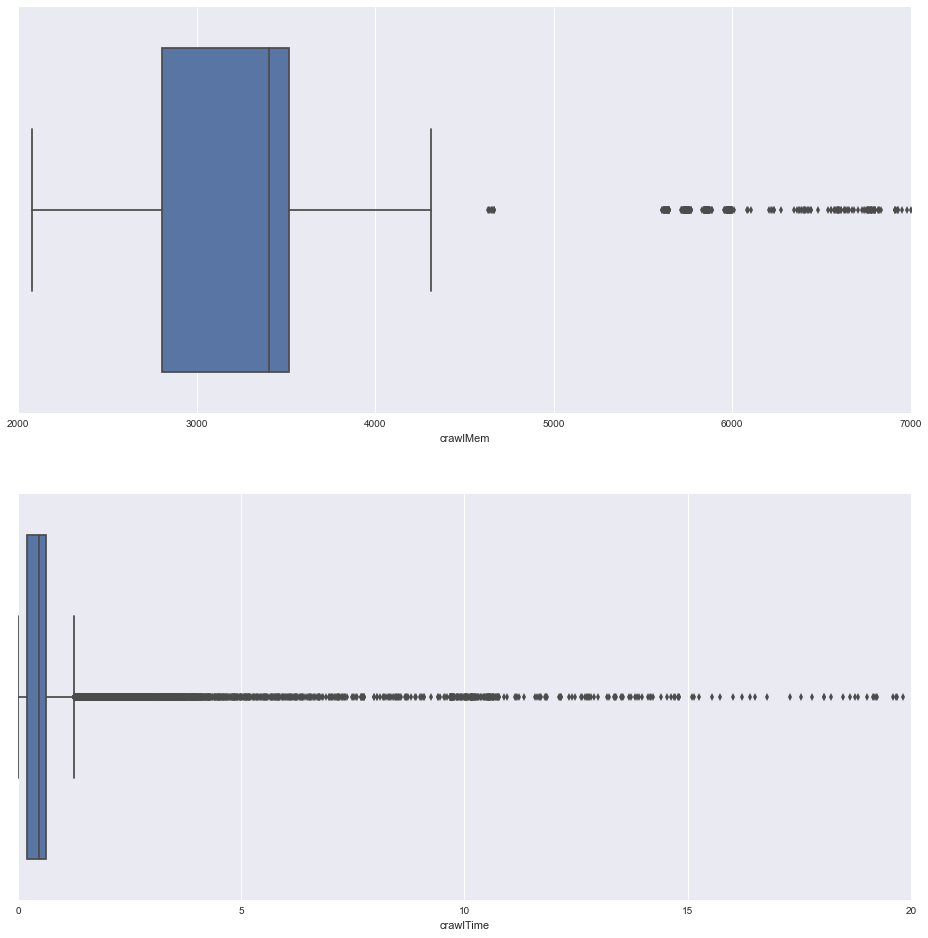

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2,figsize=(16,16))

sns.boxplot(DA5.crawlMem, orient = 'h',ax=ax[0])
sns.boxplot(DA5[DA5.crawlTime < 20].crawlTime, orient = 'h', ax=ax[1])

plt.show()

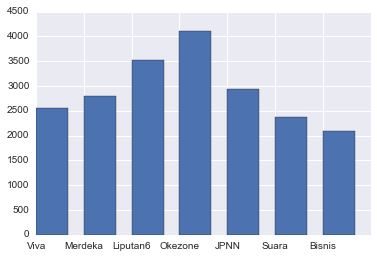

[2547.0440835266822,
 2804.0030200075498,
 3527.3853002550427,
 4113.5028396679772,
 2936.0,
 2373.6600441501105,
 2088.0]

In [7]:
import matplotlib.pyplot as plt

y = [DA5[DA5.sumber == i].crawlMem.mean() for i in [1,2,3,5,6,7,8]]
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width)
plt.xticks( range(7), ('Viva', 'Merdeka', 'Liputan6', 'Okezone', 'JPNN','Suara','Bisnis') )
plt.show()
y

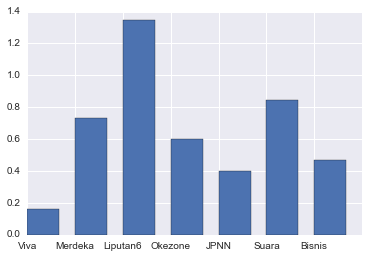

[0.16393132250580048,
 0.73384002453756125,
 1.3461580523997214,
 0.60361358671909116,
 0.39825286923800568,
 0.84458995584988961,
 0.46703199999999995]

In [9]:
import matplotlib.pyplot as plt

y = [DA5[DA5.sumber == i].crawlTime.mean() for i in [1,2,3,5,6,7,8]]
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width)
plt.xticks( range(7), ('Viva', 'Merdeka', 'Liputan6', 'Okezone', 'JPNN','Suara','Bisnis') )
plt.show()
y

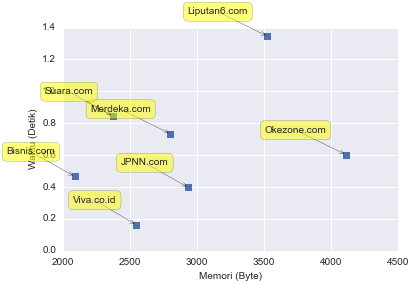

In [10]:
import numpy as np
import matplotlib.pyplot as plt

DATACrawl = DA5
x = [1,2,3,5,6,7,8]
labels = ['Viva.co.id',  'Merdeka.com', 'Liputan6.com', 'Okezone.com', 'JPNN.com', 'Suara.com', 'Bisnis.com']
y1 = [DATACrawl[DATACrawl.sumber == i].crawlMem.mean() for i in x]
y2 = [DATACrawl[DATACrawl.sumber == i].crawlTime.mean() for i in x]

plt.plot(y1, y2,'s')
plt.xlabel('Memori (Byte)', fontsize=10)
plt.ylabel('Waktu (Detik)', fontsize=10)
for label, x, y in zip(labels, y1, y2):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
plt.show()

In [11]:
crawlTime_weird = DA5[DA5.crawlTime > DA5.crawlTime.quantile(0.75)]
print 'Paling Lama'
crawlTime_weird.sort_values(by='crawlTime', ascending=False).head(1).transpose()

Paling Lama


id,28575
created_at,2016-05-14 11:00:44
updated_at,NaT
sumber,3
url,http://health.liputan6.com/read/2506400/senima...
judul,Seniman Muda Jual Puting dan Pusarnya
shortDesc,"\n <img src=""http://cdn1-a.production..."
longDesc,"Liputan6.com, Jakarta Ada-ada saja kelakuan se..."
published,2016-05-14 03:00:53
crawlTime,12196.8
crawlMem,3408


In [12]:
crawlTime_weird = DA5[DA5.crawlMem > DA5.crawlMem.quantile(0.75)]
print 'Paling Berat'
crawlTime_weird.sort_values(by='crawlMem', ascending=False).head(1).transpose()

Paling Berat


id,47882
created_at,2016-05-31 19:01:12
updated_at,NaT
sumber,5
url,http://economy.okezone.com/read/2016/05/31/320...
judul,"Sate Ayam di Pinggiran Rp12 Ribu, Masuk Tesate..."
shortDesc,"Direktur Utama AP II Budi Karya Sumadi, mengis..."
longDesc,\t\t\t\t\t\t\tJAKARTA - Direktur Utama AP II B...
published,2016-05-31 11:59:55
crawlTime,19.7019
crawlMem,7000


In [14]:
DATA_ANALSISIS_crawlPos = DA5[DA5.flag == 1]
DATA_ANALSISIS_crawlNeg = DA5
crawlAnalysis = pd.DataFrame([DATA_ANALSISIS_crawlPos.crawlMem,DATA_ANALSISIS_crawlPos.crawlTime,
                              DATA_ANALSISIS_crawlNeg.crawlMem,DATA_ANALSISIS_crawlNeg.crawlTime]).transpose()
crawlAnalysis.columns = ['Memory Pos','Time Pos','Memory Total','Time Total']
print 'Memory Pos   : ',DATA_ANALSISIS_crawlPos.crawlMem.sum(), 'Byte'
print 'Memory Total : ',DATA_ANALSISIS_crawlNeg.crawlMem.sum(), 'Byte'
print 'Time Pos     : ',DATA_ANALSISIS_crawlPos.crawlTime.sum(), 'Detik'
print 'Time Total   : ',DATA_ANALSISIS_crawlNeg.crawlTime.sum(),'Detik'
crawlAnalysis.describe()

Memory Pos   :  1390864.0 Byte
Memory Total :  143741512.0 Byte
Time Pos     :  226.653 Detik
Time Total   :  42433.5165 Detik


,Memory Pos,Time Pos,Memory Total,Time Total
count,399.000000,399.000000,42746.000000,42746.000000
mean,3485.874687,0.568053,3362.689187,0.992690
std,760.059224,2.974858,587.077727,59.015039
min,2368.000000,0.046600,2080.000000,0.000000
25%,2808.000000,0.131350,2808.000000,0.210900
50%,3912.000000,0.146100,3408.000000,0.467200
75%,4072.000000,0.304900,3520.000000,0.625200
max,6832.000000,55.697400,7000.000000,12196.766600


In [85]:
print 'Contoh Teks yang berhasil diambil: \n'
print '"'+DATA_JUDUL[58018]+'"\n'
print '"'+DATA_SHORT[58018]+'"\n'
print '"'+DATA_LONG[58018]+'"\n'

Contoh Teks yang berhasil diambil: 

"MNC Kapital akan Rights Issue Semester II 2016"

"
				<img src="http://media.suara.com/thumbnail/api/images/2016/06/08/o_1aknc4kgdbclojk1fqr1m58akha.jpg?s=653x366" align="left" hspace="7" width="100" />
				 Dari aksi rights issue terse-but, perseroan membidik dana hingga Rp 1 triliun.  
			"

"                                                    Suara.com - PT MNC Kapital Indonesia Tbk (BCAP) berencana menambah modal dengan menerbitkan saham tanpa hak memesan efek terlebih dahulu (non-HMETD) pada semester II mendatang. Dari aksi rights issue terse-but, perseroan membidik dana hingga Rp 1 triliun.Informasit tersebut tertuang dalam keterangan resmi Managing Partner PT Investa Saran Mandiri Kiswoyo Adi Joe, Rabu (9/6/2016).Selain untuk injeksi modal anak usahanya, dana segar yang diperoleh dari non-HMETD akan digunakan untuk melakukan ekspansi anorganik. Tahun ini, BCAP mencari peluang untuk mengakuisisi beberapa bank dan bisnis asuransi. Sebagai inf

In [ ]:
DATA_JUDUL_words = [len(word.split()) for word in DATA_JUDUL]
DATA_SHORT_words = [len(word.split()) for word in DATA_SHORT]
DATA_LONG_words  = [len(word.split()) for word in DATA_LONG]
DATA_FEED1_words  = [len(word.split()) for word in DATA_FEED1]
DATA_FEED2_words  = [len(word.split()) for word in DATA_FEED2]
count_word = pd.DataFrame([DATA_JUDUL_words,DATA_SHORT_words,DATA_LONG_words,DATA_FEED1_words,DATA_FEED2_words]).transpose()
count_word.columns = ['Judul','Short','Long','Feed1','Feed2']
print 'Deskripsi mengenai jumlah kata :'
count_word.describe()

Deskripsi mengenai jumlah kata :


,Judul,Short,Long,Feed1,Feed2
count,42746.000000,42746.000000,42746.000000,42746.000000,42746.000000
mean,8.235461,15.651336,275.928344,23.886796,299.815141
std,1.635129,6.019051,141.117667,6.138289,141.052133
min,2.000000,1.000000,3.000000,6.000000,15.000000
25%,7.000000,13.000000,194.000000,21.000000,218.000000
50%,8.000000,15.000000,246.000000,24.000000,270.000000
75%,9.000000,17.000000,322.000000,26.000000,345.000000
max,15.000000,326.000000,4499.000000,333.000000,4516.000000


## Little Cleaning

In [86]:
print 'Contoh Teks yang telah dihilangkan karakter Alphanumeric dan tag HTML: \n'
print '"'+strip_tags(DATA_JUDUL[58018])+'"\n'
print '"'+strip_tags(DATA_SHORT[58018])+'"\n'
print '"'+strip_tags(DATA_LONG[58018])+'"\n'

Contoh Teks yang telah dihilangkan karakter Alphanumeric dan tag HTML: 

"mnc kapital akan rights issue semester ii 2016"

"dari aksi rights issue terse-but, perseroan membidik dana hingga rp 1 triliun."

"suara.com - pt mnc kapital indonesia tbk (bcap) berencana menambah modal dengan menerbitkan saham tanpa hak memesan efek terlebih dahulu (non-hmetd) pada semester ii mendatang. dari aksi rights issue terse-but, perseroan membidik dana hingga rp 1 triliun.informasit tersebut tertuang dalam keterangan resmi managing partner pt investa saran mandiri kiswoyo adi joe, rabu (9/6/2016).selain untuk injeksi modal anak usahanya, dana segar yang diperoleh dari non-hmetd akan digunakan untuk melakukan ekspansi anorganik. tahun ini, bcap mencari peluang untuk mengakuisisi beberapa bank dan bisnis asuransi. sebagai informasi, pada 1 juni lalu, bcap juga sudah melakukan non-hmetd sebanyak 232,2 juta saham baru dengan nilai nominal rp 100. harga pelaksanaan rights issue tersebut sebesar rp 1.658 pe

## Vectorization

In [10]:
#Stopwords data source : https://www.illc.uva.nl/Research/Publications/Reports/MoL-2003-02.text.pdf
stopword_html = open("id.stopwords.01.01.2016.txt",'r').read()
stopwords     = stopword_html.split("\n")

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

def tableTop10(a,b):    
    def topKWords(docs,k):
        dummy  = docs.tolist()
        countv = CountVectorizer(stop_words=stopwords,decode_error='ignore')
        dummy  = countv.fit_transform(dummy)
        freqs = [(word, dummy.getcol(idx).sum()) for word, idx in countv.vocabulary_.items()]
        #sort from largest to smallest
        return [name for name,freq in sorted(freqs, key = lambda x: -x[1])[0:k]]
    top_word = pd.DataFrame([topKWords(a,10),
                             topKWords(b,10),
                            ]).transpose()
    return top_word

In [8]:
DATA_FEED1 = DATA_JUDUL+' '+DATA_SHORT
DATA_FEED2 = DATA_JUDUL+' '+DATA_LONG+' '+DATA_SHORT

DATA_FEED1Striped = DATA_JUDULStriped+' '+DATA_SHORTStriped
DATA_FEED2Striped = DATA_JUDULStriped+' '+DATA_LONGStriped+' '+DATA_SHORTStriped

## Top 10

In [ ]:
top_wordBerita = tableTop10(DATA_FEED1,DATA_FEED2)
top_wordBerita.columns = ['X1','X2']
print '10 Kata paling tinggi Frekuensinya Pada teks Sebelum preprocessing'
top_wordBerita

In [ ]:
top_wordBerita = tableTop10(DATA_FEED1Striped,DATA_FEED2Striped)
top_wordBerita.columns = ['X1','X2']
print '10 Kata paling tinggi Frekuensinya Pada teks setelah preprocessing'
top_wordBerita

In [94]:
top_wordBerita = tableTop10(DATA_FEED1_sk,DATA_FEED2_sk)
top_wordBerita.columns = ['X1_sk','X2_sk']
print '10 Kata paling tinggi Frekuensinya Pada teks Sebelum preprocessing SK'
top_wordBerita

10 Kata paling tinggi Frekuensinya Pada teks Sebelum preprocessing SK


,X1_sk,X2_sk
0,align,air
1,com,lion
2,air,nbsp
3,lion,saham
4,100,persen
5,img,2016
6,hspace,pt
7,left,jakarta
8,src,indonesia
9,width,penerbangan


In [95]:
top_wordBerita = tableTop10(DATA_FEED1Striped_sk,DATA_FEED2Striped_sk)
top_wordBerita.columns = ['X1_sk','X2_sk']
print '10 Kata paling tinggi Frekuensinya Pada teks Sebelum preprocessing SK'
top_wordBerita

10 Kata paling tinggi Frekuensinya Pada teks Sebelum preprocessing SK


,X1_sk,X2_sk
0,air,air
1,lion,lion
2,mnc,saham
3,pt,persen
4,saham,2016
5,tbk,pt
6,astra,jakarta
7,securities,indonesia
8,indonesia,penerbangan
9,triliun,perseroan


### Insight

1. ##### Kata 'JPNN'
    Kata 'JPNN' adalah header setiap berita yang terdapat di rss feed jpnn.com
   
2. ##### Kata '2016'
   Kok gak ilang ?, karena dianggap bukan stopword meskipun ga mengandung informasi yang relevan

## Word Cloud

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def word3Cloud(a,b,title):
    fig, axes = plt.subplots(ncols=2,figsize=(10,5))

    # join tweets to a single string
    aWord = ' '.join(a)
    bWord = ' '.join(b)

    judulCloud = WordCloud(background_color='white',stopwords=stopwords,
                          width=4000,
                          height=4200
                         ).generate(aWord)
    shortCloud = WordCloud(background_color='white',stopwords=stopwords,
                          width=4000,
                          height=4200
                         ).generate(bWord)
    
    axes[0].imshow(judulCloud)
    axes[0].axis('off')
    axes[0].set_title('Feed1')

    axes[1].imshow(shortCloud)
    axes[1].axis('off')
    axes[1].set_title('Feed2')

    fig.suptitle(title)
    fig.savefig('img/'+title+'.png', dpi=300)
    fig.show()

C:\Users\Thosan Girisona S\Anaconda\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


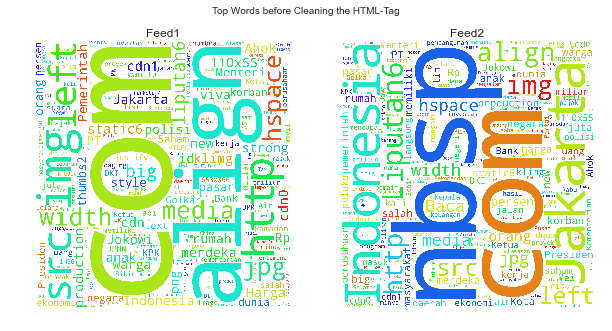

In [11]:
word3Cloud(DATA_FEED1,
           DATA_FEED2,
           'Top Words before Cleaning the HTML-Tag')

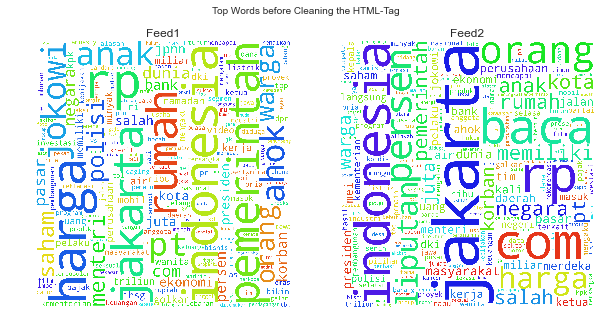

In [12]:
word3Cloud(DATA_FEED1Striped,
           DATA_FEED2Striped,
           'Top Words before Cleaning the HTML-Tag')

In [124]:
print DA3.count()
print DA3[DA3.flag.isin([-1,1])][DA3.crawlMem.notnull()].count()
print DA3[DA3.flag.isin([1])][DA3.crawlMem.notnull()].count()

created_at    1032
updated_at     872
sumber        1344
url           1344
judul         1344
shortDesc     1344
longDesc      1344
published     1021
crawlTime     1344
crawlMem      1344
flag          1344
dtype: int64
created_at    1032
updated_at     872
sumber        1344
url           1344
judul         1344
shortDesc     1344
longDesc      1344
published     1021
crawlTime     1344
crawlMem      1344
flag          1344
dtype: int64
created_at    384
updated_at    247
sumber        399
url           399
judul         399
shortDesc     399
longDesc      399
published     383
crawlTime     399
crawlMem      399
flag          399
dtype: int64


## PCA

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.feature_extraction.text import CountVectorizer
# import seaborn as sns

# fs = 10
# almost_black = '#262626'
# sns.set()


# X1 = tfidfv.fit_transform(DATA_JUDUL).toarray()
# X2 = tfidfv.fit_transform(DATA_SHORT).toarray()
# X3 = tfidfv.fit_transform(DATA_LONG).toarray()
# y = DATA_TARGET.as_matrix()

# # Instanciate a PCA object for the sake of easy visualisation
# pca1 = PCA(n_components=2)
# pca2 = PCA(n_components=2)
# pca3 = PCA(n_components=2)

# # Fit and transform x to visualise inside a 2D feature space
# x1_vis = pca1.fit_transform(X1)
# x2_vis = pca2.fit_transform(X2)
# x3_vis = pca3.fit_transform(X3)

# fig, axes = plt.subplots(ncols=3,figsize=(15,5))
# # Plot the original data
# palette = sns.color_palette()
# axes[0].scatter(x1_vis[y == -1, 0], x1_vis[y == -1, 1], label="Class #Negatif", alpha=0.5, 
#             edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
# axes[0].scatter(x1_vis[y == 1, 0], x1_vis[y == 1, 1], label="Class #Positif", alpha=0.5, 
#             edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
# axes[0].set_title('Judul', fontsize=fs)

# axes[1].scatter(x2_vis[y == -1, 0], x2_vis[y == -1, 1], label="Class #Negatif", alpha=0.5, 
#             edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
# axes[1].scatter(x2_vis[y == 1, 0], x2_vis[y == 1, 1], label="Class #Positif", alpha=0.5, 
#             edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
# axes[1].set_title('Short Description', fontsize=fs)

# axes[2].scatter(x3_vis[y== -1, 0], x3_vis[y == -1, 1], label="Class #Negatif", alpha=0.5, 
#             edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
# axes[2].scatter(x3_vis[y == 1, 0], x3_vis[y == 1, 1], label="Class #Positif", alpha=0.5, 
#             edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
# axes[2].set_title('Long Description', fontsize=fs)

# fig.suptitle('Gambaran 2 Dimensi 3 jenis Teks Berita (HTML and Stopwords Free)')
# fig.show()
# fig.savefig('img/PCA2.png', dpi=300)

## Explained Variance

In [ ]:
# print pca1.explained_variance_ratio_.sum() * 100
# print pca2.explained_variance_ratio_.sum() * 100
# print pca3.explained_variance_ratio_.sum() * 100

In [ ]:
# print 'Jumlah Rata-rata kata teks Judul dan Keberagaman kata   : ',count_word.Judul.mean(),' ',X1.shape[1]
# print 'Jumlah Rata-rata kata teks Short dan Keberagaman kata   : ',count_word.Short.mean(),' ',X2.shape[1]
# print 'Jumlah Rata-rata kata teks Lengkap dan Keberagaman kata : ',count_word.Long.mean(),' ',X3.shape[1]

In [97]:
pickle.dump( DA3, open( "v1.4\DATA_CRAWL-v4a.p", "wb" ) )
pickle.dump( DATA_TARGET, open( "v1.4\DATA_TARGET-v4a.p", "wb" ) )

pickle.dump( DATA_JUDUL, open( "v1.4\DATA_JUDUL-v4a.p", "wb" ) )
pickle.dump( DATA_SHORT, open( "v1.4\DATA_SHORT-v4a.p", "wb" ) )
pickle.dump( DATA_LONG, open( "v1.4\DATA_LONG-v4a.p", "wb" ) )
pickle.dump( DATA_FEED1, open( "v1.4\DATA_FEED1-v4a.p", "wb" ) )
pickle.dump( DATA_FEED2, open( "v1.4\DATA_FEED2-v4a.p", "wb" ) )

pickle.dump(DATA_JUDULStriped,open( "v1.4\DATA_JUDULStriped-v4a.p", "wb" ))
pickle.dump(DATA_SHORTStriped,open( "v1.4\DATA_SHORTStriped-v4a.p", "wb" ))
pickle.dump(DATA_LONGStriped,open( "v1.4\DATA_LONGStriped-v4a.p", "wb" ))
pickle.dump(DATA_FEED1Striped,open( "v1.4\DATA_FEED1Striped-v4a.p", "wb" ))
pickle.dump(DATA_FEED2Striped,open( "v1.4\DATA_FEED2Striped-v4a.p", "wb" ))

In [56]:
pickle.dump( DA6, open( "v1.4\DATA_CRAWL-v4c.p", "wb" ) )
pickle.dump( DATA_TARGET_skb, open( "v1.4\DATA_TARGET-v4c.p", "wb" ) )

pickle.dump( DATA_JUDUL_skb, open( "v1.4\DATA_JUDUL-v4c.p", "wb" ) )
pickle.dump( DATA_SHORT_skb, open( "v1.4\DATA_SHORT-v4c.p", "wb" ) )
pickle.dump( DATA_LONG_skb, open( "v1.4\DATA_LONG-v4b.c", "wb" ) )
pickle.dump( DATA_FEED1_skb, open( "v1.4\DATA_FEED1-v4c.p", "wb" ) )
pickle.dump( DATA_FEED2_skb, open( "v1.4\DATA_FEED2-v4c.p", "wb" ) )

pickle.dump(DATA_JUDULStriped_skb,open( "v1.4\DATA_JUDULStriped-v4c.p", "wb" ))
pickle.dump(DATA_SHORTStriped_skb,open( "v1.4\DATA_SHORTStriped-v4c.p", "wb" ))
pickle.dump(DATA_LONGStriped_skb,open( "v1.4\DATA_LONGStriped-v4c.p", "wb" ))
pickle.dump(DATA_FEED1Striped_skb,open( "v1.4\DATA_FEED1Striped-v4c.p", "wb" ))
pickle.dump(DATA_FEED2Striped_skb,open( "v1.4\DATA_FEED2Striped-v4c.p", "wb" ))

In [26]:
pickle.dump(DTEST,open( "v1.4\DTEST-v1.p", "wb" ))
pickle.dump(DTRAIN,open( "v1.4\DTRAIN-v1.p", "wb" ))